In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [3]:
wid = 80
oversample = 4

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)

# n458
data = '../data/MAST_2024-09-19T06_48_02.332Z/HST/'

# n581
data = '../data/MAST_2024-09-23T06_53_22.463Z/HST/'

#hyades
data = '../data/MAST_2024-09-26T22_53_13.719Z/HST/'

data = '../data/MAST_2024-09-27T00_15_31.056Z/HST/'

files = """
na2a04maq_cal.fits
na2a04mbq_cal.fits
na2a04meq_cal.fits
na2a04mgq_cal.fits
na2a04mjq_cal.fits
na2a04mlq_cal.fits
na2a04moq_cal.fits
na2a04mqq_cal.fits
na2a04mtq_cal.fits
na2a04mvq_cal.fits
na2a04myq_cal.fits
na2a04n0q_cal.fits
na2a04n3q_cal.fits
na2a04n5q_cal.fits
na2a04n8q_cal.fits
na2a04naq_cal.fits
na2a04ndq_cal.fits
na2a04neq_cal.fits
""".split()


exposures = [

    # N458
    exposure_from_file(data+'na2a05ttq_cal.fits', SinglePointFit(), crop=wid),
    exposure_from_file(data+'na2a05tuq_cal.fits', SinglePointFit(), crop=wid),
    exposure_from_file(data+"na2a05txq_cal.fits", SinglePointFit(), crop=wid),
    exposure_from_file(data+"na2a05tzq_cal.fits", SinglePointFit(), crop=wid),
    exposure_from_file(data+"na2a05u2q_cal.fits", SinglePointFit(), crop=wid),
    exposure_from_file(data+"na2a05u4q_cal.fits", SinglePointFit(), crop=wid),
    exposure_from_file(data+"na2a05u7q_cal.fits", SinglePointFit(), crop=wid),
    exposure_from_file(data+"na2a05u9q_cal.fits", SinglePointFit(), crop=wid),
    exposure_from_file(data+"na2a05ueq_cal.fits", SinglePointFit(), crop=wid),
    exposure_from_file(data+"na2a05uhq_cal.fits", SinglePointFit(), crop=wid),
    exposure_from_file(data+"na2a05ujq_cal.fits", SinglePointFit(), crop=wid),
    exposure_from_file(data+"na2a05umq_cal.fits", SinglePointFit(), crop=wid),
    exposure_from_file(data+"na2a05uoq_cal.fits", SinglePointFit(), crop=wid),
    exposure_from_file(data+"na2a05urq_cal.fits", SinglePointFit(), crop=wid),
    exposure_from_file(data+"na2a05utq_cal.fits", SinglePointFit(), crop=wid),
    exposure_from_file(data+"na2a05uwq_cal.fits", SinglePointFit(), crop=wid),
    exposure_from_file(data+"na2a05uxq_cal.fits", SinglePointFit(), crop=wid),


    # N581
    #exposure_from_file(data+'na2a04maq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a04mbq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a04meq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a04mgq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a04mjq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a04mlq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a04moq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a04mqq_cal.fits', SinglePointFit(), crop=wid),


    #exposure_from_file(data+'na2a04mcq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a04mdq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a04mhq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a04miq_cal.fits', SinglePointFit(), crop=wid),


    #exposure_from_file(data+'na2a08phq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a08piq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a26f7q_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a26faq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a02b6q_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(data+'na2a02b8q_cal.fits', SinglePointFit(), crop=wid),
]

#exposures = [exposure_from_file(data+f, SinglePointFit(), crop=wid) for f in files]#[:18]

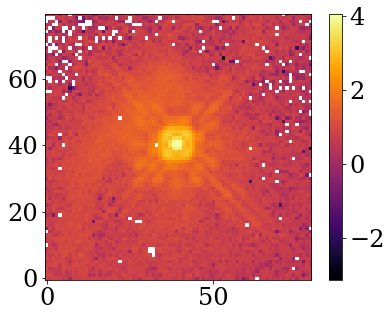

In [4]:
n = 0
plt.imshow(np.log10(exposures[n].data/exposures[n].err))
plt.colorbar()

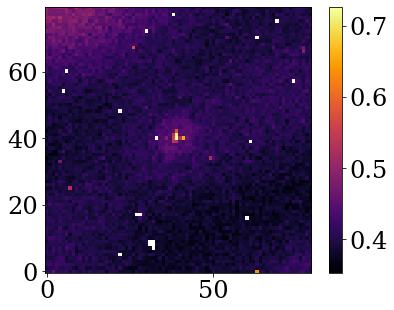

In [5]:
plt.imshow(exposures[0].err)
plt.colorbar()

In [6]:
params = {
    "fluxes": {},
    "positions": {},
    "slope": {},
    "contrast": {},
    #"separation": 6.,#18.,
    #"position_angle": 45.,#30.,#80.,#40.,
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    #"scale": 0.0434735,
    #"rot": 0.0
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])#np.asarray([-6.,-7.])#np.asarray([-8.,-2.])#np.asarray([-6.,-7.])
    params["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.log10(np.nansum(exp.data))
    params["slope"][exp.fit.get_key(exp, "slope")] = np.zeros(5)#.at[0].set(1)
    #params["aberrations"] = injected_params["aberrations"]
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)#jr.uniform(jr.key(0), (8,),minval=-4e-8, maxval=4e-8) #np.asarray([-8.59023084e-10,  1.77049982e-09, -4.45293089e-09, -3.70890613e-08,2.03658617e-08,  1.08092528e-08, -2.77077727e-09,  1.86458672e-09])*0.9#jr.uniform(jr.key(0), (8,),minval=-2e-8, maxval=2e-8)#np.zeros(8)#np.ones(8)*1e-8
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([0.06, 0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = 45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = 45.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    #params["contrast"][exp.fit.get_key(exp, "contrast")] = 1.


model = set_array(NICMOSModel(exposures, params, optics, detector))

params = ModelParams(params)

In [7]:
params

ModelParams(
  params={
    'fluxes':
    {'F110W': f32[]},
    'positions':
    {
      'na2a05ttq':
      f32[2],
      'na2a05tuq':
      f32[2],
      'na2a05txq':
      f32[2],
      'na2a05tzq':
      f32[2],
      'na2a05u2q':
      f32[2],
      'na2a05u4q':
      f32[2],
      'na2a05u7q':
      f32[2],
      'na2a05u9q':
      f32[2],
      'na2a05ueq':
      f32[2],
      'na2a05uhq':
      f32[2],
      'na2a05ujq':
      f32[2],
      'na2a05umq':
      f32[2],
      'na2a05uoq':
      f32[2],
      'na2a05urq':
      f32[2],
      'na2a05utq':
      f32[2],
      'na2a05uwq':
      f32[2],
      'na2a05uxq':
      f32[2]
    },
    'slope':
    {'F110W': f32[5]},
    'contrast':
    {},
    'aberrations':
    {
      'na2a05ttq':
      f32[26],
      'na2a05tuq':
      f32[26],
      'na2a05txq':
      f32[26],
      'na2a05tzq':
      f32[26],
      'na2a05u2q':
      f32[26],
      'na2a05u4q':
      f32[26],
      'na2a05u7q':
      f32[26],
      'na2a05u9q':
      f3

In [8]:
print(params.params)

{'fluxes': {'F110W': Array(5.005549, dtype=float32)}, 'positions': {'na2a05ttq': Array([0., 0.], dtype=float32), 'na2a05tuq': Array([0., 0.], dtype=float32), 'na2a05txq': Array([0., 0.], dtype=float32), 'na2a05tzq': Array([0., 0.], dtype=float32), 'na2a05u2q': Array([0., 0.], dtype=float32), 'na2a05u4q': Array([0., 0.], dtype=float32), 'na2a05u7q': Array([0., 0.], dtype=float32), 'na2a05u9q': Array([0., 0.], dtype=float32), 'na2a05ueq': Array([0., 0.], dtype=float32), 'na2a05uhq': Array([0., 0.], dtype=float32), 'na2a05ujq': Array([0., 0.], dtype=float32), 'na2a05umq': Array([0., 0.], dtype=float32), 'na2a05uoq': Array([0., 0.], dtype=float32), 'na2a05urq': Array([0., 0.], dtype=float32), 'na2a05utq': Array([0., 0.], dtype=float32), 'na2a05uwq': Array([0., 0.], dtype=float32), 'na2a05uxq': Array([0., 0.], dtype=float32)}, 'slope': {'F110W': Array([0., 0., 0., 0., 0.], dtype=float32)}, 'contrast': {}, 'aberrations': {'na2a05ttq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [9]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 2e-4

things = {
    "fluxes" : opt(g*100,20),
    "positions": opt(g*5, 0),
    "cold_mask_shift": opt(g*2000, 40),
    "cold_mask_scale": opt(g*500, 120),
    "cold_mask_rot": opt(g*500, 40),
    "cold_mask_shear": opt(g*500, 40),
    #"primary_scale": opt(g*1000, 200),
    #"primary_rot": opt(g*1000, 200),
    #"primary_shear": opt(g*1000, 200),
    "aberrations": opt(g*10,40),
    "slope": opt(g*1000, 60),
    #"separation": opt(g*30, 0),
    #"contrast": opt(g*20, 20),
    #"position_angle": opt(g*20, 0)
    #"rot": opt(g*100, 50),
    #"spider_width": opt(g*500, 60),
}

#g = 2e-3

g = 2e-3

things = {
    "fluxes" : opt(g*20,10),
    "positions": opt(g*3, 0),
    #"positions": opt(g*200, 0),
    "cold_mask_shift": opt(g*100, 120),
    "cold_mask_rot": opt(g*100, 120),
    "cold_mask_scale": opt(g*1000, 150),
    "cold_mask_shear": opt(g*10, 150),
    #"primary_scale": opt(g*100, 150),
    #"primary_rot": opt(g*100, 150),
    #"primary_shear": opt(g*100, 150),
    "aberrations": opt(g*10,120),
    "slope": opt(g*20, 50),
    #"softening": opt(g*1e3, 200),
    #"breathing": opt(g*1000,150),
    #"rot": opt(g*100, 50),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [10]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths)
def loss_fn(params,exposures):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [11]:
rc = False
fishers = calc_fishers(model, exposures, paths, recalculate=rc)
lrs = calc_lrs(model, exposures, fishers, paths)

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [12]:
lrs.params

{'aberrations': {'na2a05ttq': Array([4.6435842e-05, 3.1424555e-05, 2.6171909e-05, 4.3023440e-05,
         4.2570478e-05, 5.1691812e-05, 5.1999090e-05, 6.1234809e-05,
         2.4274936e-05, 3.0773517e-05, 3.7314236e-05, 3.2690965e-05,
         4.1953936e-05, 4.2276548e-05, 3.3104810e-05, 3.3095370e-05,
         4.0382685e-05, 4.0810701e-05, 3.2377313e-05, 3.0532028e-05,
         2.4357001e-05, 2.3619792e-05, 2.7285048e-05, 4.1835156e-05,
         3.5531502e-05, 3.6785594e-05], dtype=float32),
  'na2a05tuq': Array([5.3494630e-05, 3.8806611e-05, 3.0715062e-05, 5.1999887e-05,
         4.8045888e-05, 6.5268869e-05, 6.5543616e-05, 6.9874419e-05,
         2.6920252e-05, 3.5165394e-05, 4.2676282e-05, 3.7282865e-05,
         4.6595505e-05, 4.8256352e-05, 3.8031289e-05, 3.7997808e-05,
         4.6369478e-05, 4.6940186e-05, 3.6374335e-05, 3.3907254e-05,
         2.6756585e-05, 2.6254160e-05, 3.0347528e-05, 4.7473735e-05,
         4.0307074e-05, 4.1163003e-05], dtype=float32),
  'na2a05txq': Arra

In [13]:
optim, opt_state = zdx.get_optimiser(
    params, groups, optimisers
)


losses, models = [], []
for i in tqdm(range(400)):
    loss, grads = loss_fn(params,exposures)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs.params))
    updates, opt_state = optim.update(grads, opt_state)
    params = zdx.apply_updates(params, updates)

    models.append(params)
    losses.append(loss)


  0%|          | 0/400 [00:00<?, ?it/s]

In [14]:
model


NICMOSModel(
  params={
    'aberrations':
    {
      'na2a05ttq':
      f32[26],
      'na2a05tuq':
      f32[26],
      'na2a05txq':
      f32[26],
      'na2a05tzq':
      f32[26],
      'na2a05u2q':
      f32[26],
      'na2a05u4q':
      f32[26],
      'na2a05u7q':
      f32[26],
      'na2a05u9q':
      f32[26],
      'na2a05ueq':
      f32[26],
      'na2a05uhq':
      f32[26],
      'na2a05ujq':
      f32[26],
      'na2a05umq':
      f32[26],
      'na2a05uoq':
      f32[26],
      'na2a05urq':
      f32[26],
      'na2a05utq':
      f32[26],
      'na2a05uwq':
      f32[26],
      'na2a05uxq':
      f32[26]
    },
    'cold_mask_rot':
    {'F110W': f32[]},
    'cold_mask_scale':
    {'F110W': f32[2]},
    'cold_mask_shear':
    {'F110W': f32[2]},
    'cold_mask_shift':
    {'F110W': f32[2]},
    'contrast':
    {},
    'fluxes':
    {'F110W': f32[]},
    'outer_radius':
    f32[],
    'positions':
    {
      'na2a05ttq':
      f32[2],
      'na2a05tuq':
      f32[2],
      

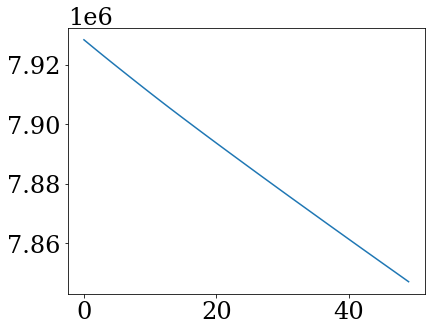

In [15]:
plt.plot(losses[-50:])

In [16]:
params.params

{'aberrations': {'na2a05ttq': Array([-1.0623367 ,  0.4146823 , -1.365315  , -0.6776965 ,  1.9242939 ,
          1.7511021 ,  0.9085668 , -2.9381907 , -1.8034067 ,  0.45499685,
          0.07017395, -0.45243883, -7.5915365 , -3.3234272 ,  0.5809364 ,
         -1.6190104 ,  0.7649097 ,  0.09537985, -0.16504252, -0.05173956,
         -0.6988067 ,  0.15392932, -0.52888364,  0.3025303 ,  0.05490936,
         -0.76722485], dtype=float32),
  'na2a05tuq': Array([ 1.6111178e+00, -1.2252442e+00, -3.1866148e+00, -6.0441737e+00,
          1.2413692e+00,  1.2038518e+00,  9.4807851e-01, -3.4711531e-01,
         -2.9847090e+00, -1.4774014e-01,  5.5760282e-01, -5.5890757e-01,
         -9.0457916e+00, -8.6145430e+00,  5.6504363e-01, -1.9288323e+00,
          9.5864236e-01,  7.8333789e-01, -1.8427598e-01,  3.2492271e-01,
         -7.6903158e-01, -6.2398082e-03, -2.0088410e-01,  1.8966012e-01,
         -4.1222490e-02, -3.2835975e-01], dtype=float32),
  'na2a05txq': Array([-2.3130293 , -0.5138201 ,  0.824

8


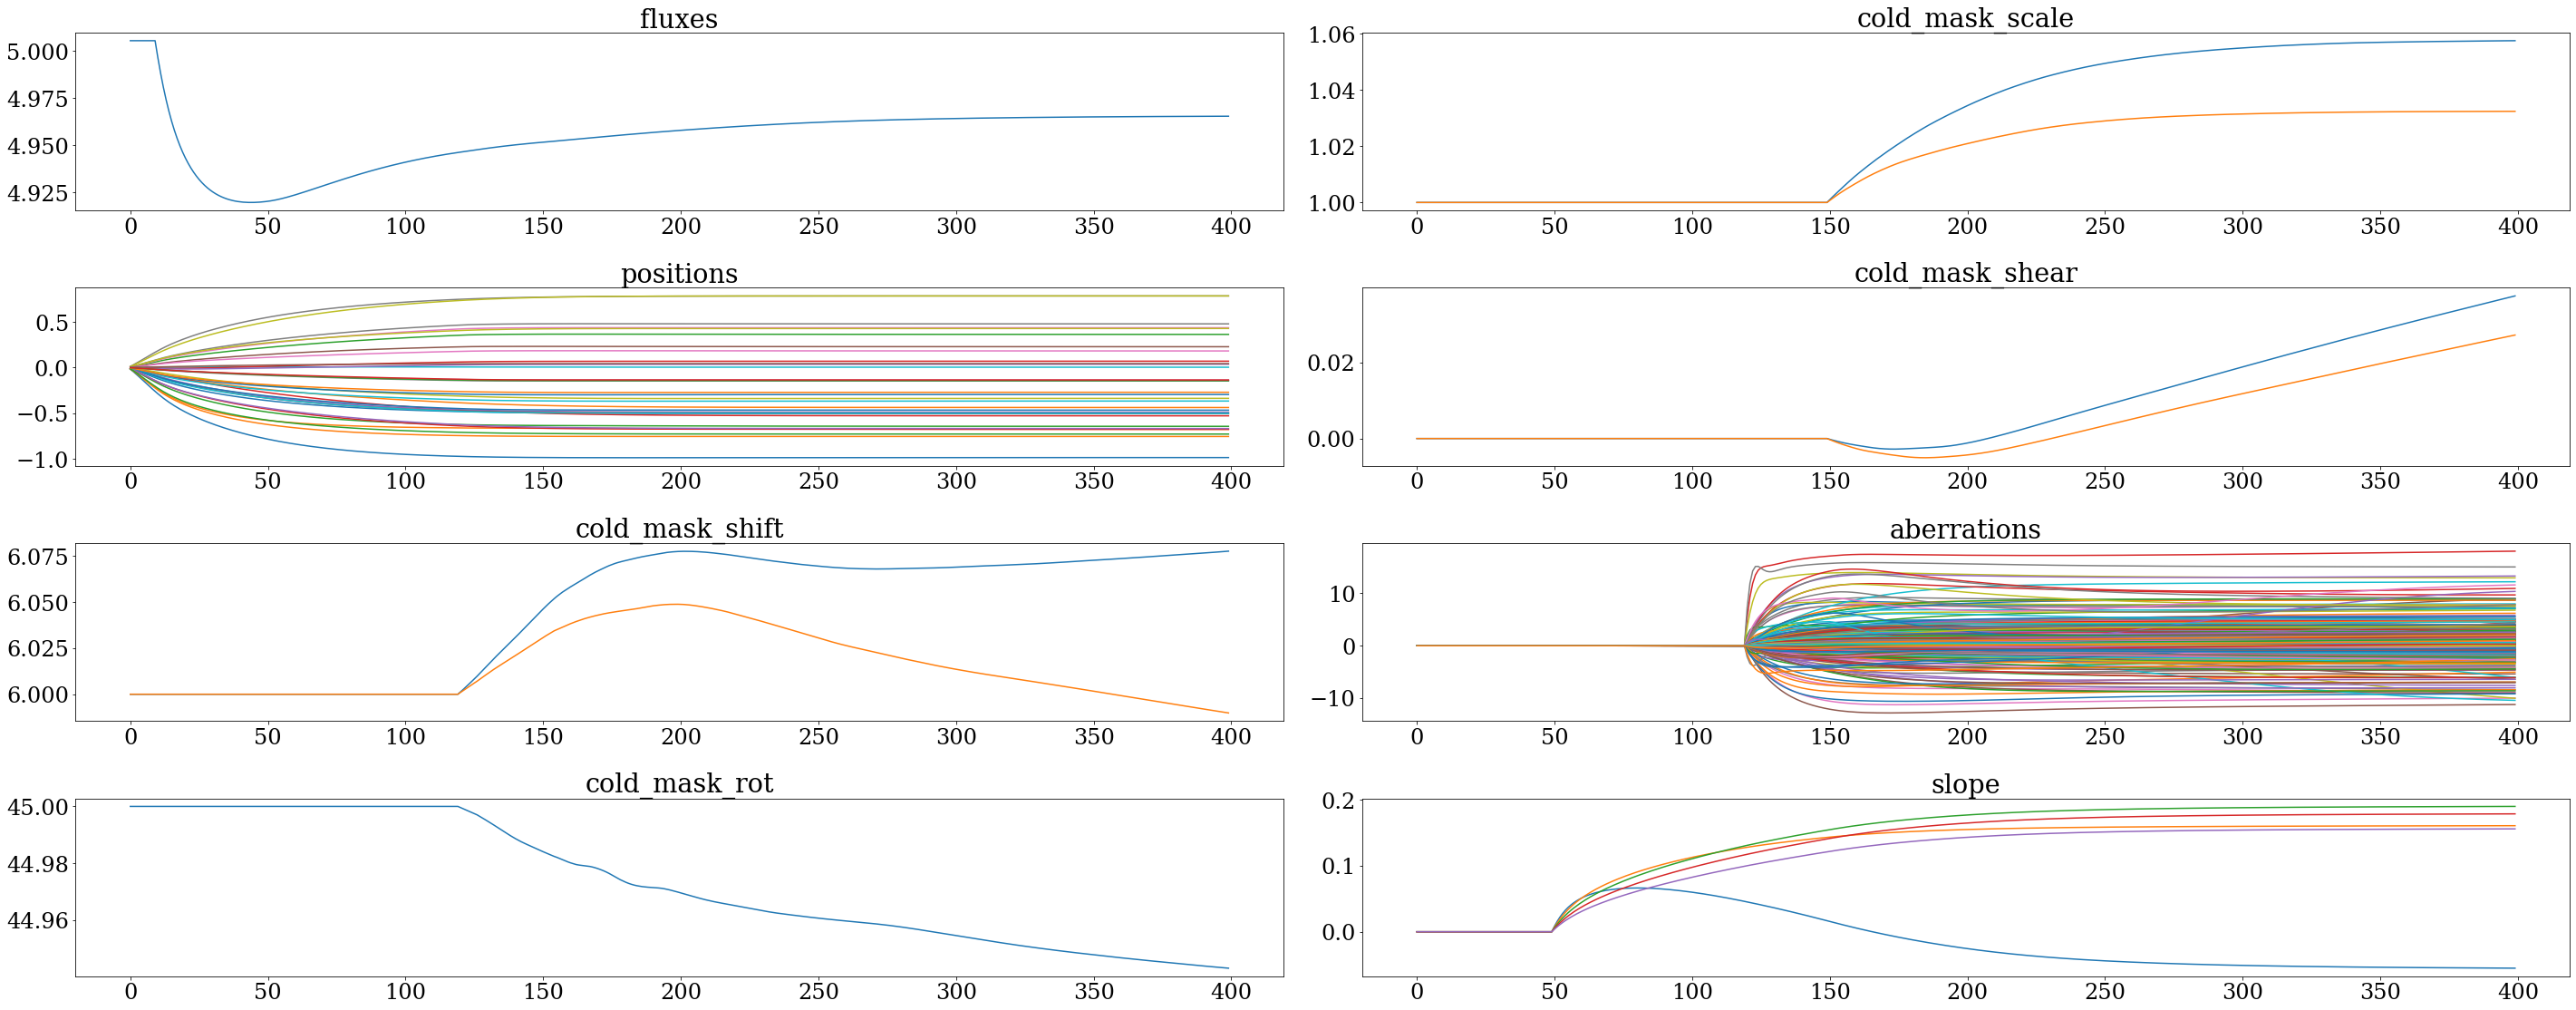

In [17]:
xw = 4
yw = int(np.ceil(len(groups)/xw))

print(len(groups))


fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions", "aberrations", 
                 "cold_mask_shift", "cold_mask_rot", "cold_mask_scale", "cold_mask_shear",
                 "primary_rot","primary_scale", "primary_shear", "slope"]:
        #print(np.asarray(list(models_s[0].get(param).values())))
        #print(injected_params[param])
        """for j in injected_params[param].values():
            print(j)
            print(len(j.shape))
            if len(j.shape)>0:
                for k in j:
                    sp.axhline(k, color='k', linestyle='--')
            else:
                sp.axhline(j, color='k', linestyle='--')"""
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models])
        #sp.axhline(injected_params[param], color='k', linestyle='--')

    
fig.tight_layout()

2.460844e+09, 7.847178e+06


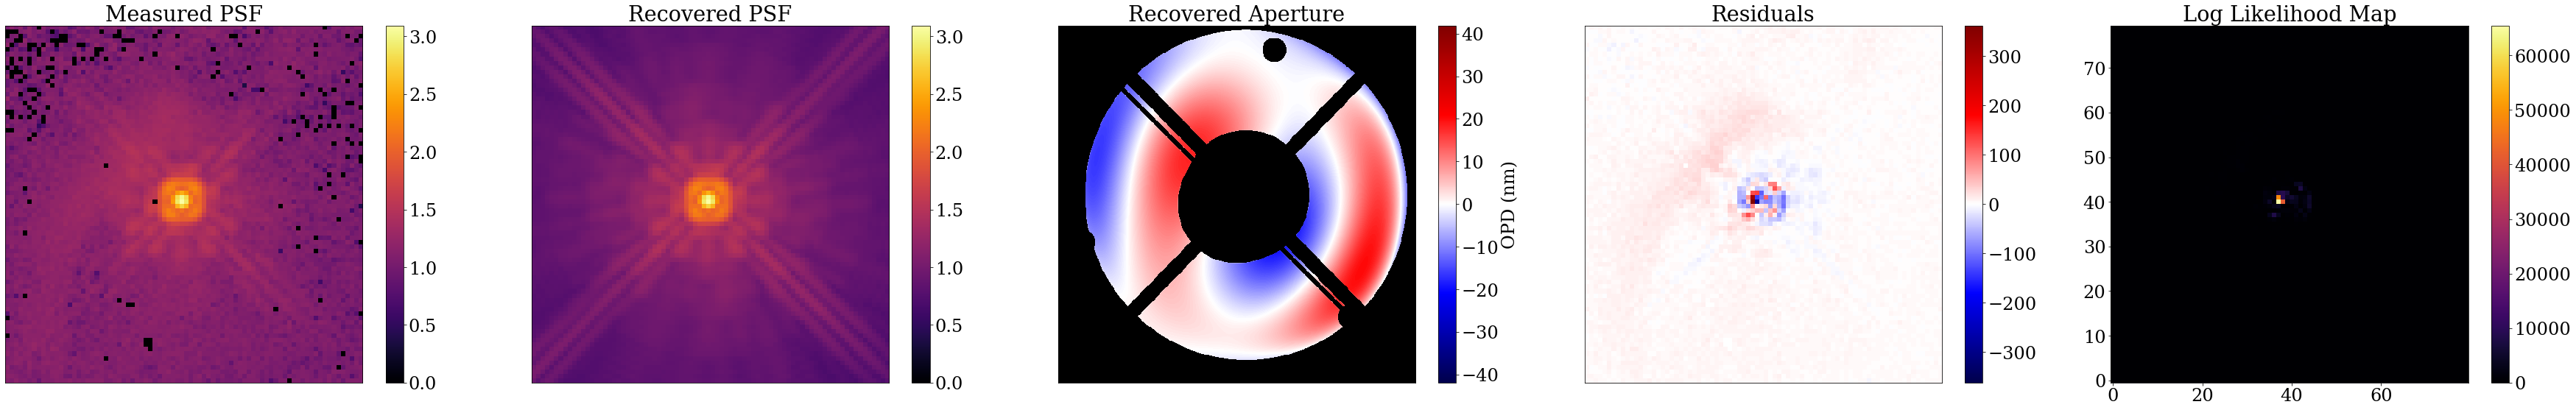

In [18]:
print(f"{float(losses[0]):e}, {float(losses[-1]):e}")

fig, axs = plt.subplots(1,5, figsize=(50,8))

fig.tight_layout()

cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

#vm = max(np.max(cropped_data),np.max(telescope.model()))

exp = exposures[0]

model = params.inject(model)

coords = dlu.pixel_coords(512, 2.4)
cropped_frame = exp.data**0.125
telescope_frame = exp.fit(model,exp)**0.125

vm = max(np.nanmax(cropped_frame),np.nanmax(telescope_frame))
cd=axs[0].imshow(cropped_frame, vmin=0,vmax=vm,cmap=cmap)
plt.colorbar(cd,ax=axs[0])
tl=axs[1].imshow(telescope_frame, vmin=0, vmax=vm,cmap=cmap)
plt.colorbar(tl,ax=axs[1])
#axs[2].imshow(cropped_err)
cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)

optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd))
apt =axs[2].imshow(support_mask*opd,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[2]).set_label("OPD (nm)")
#axs[4].imshow(telescope.detector.pixel_response.pixel_response)
resid = (exp.data - exp.fit(model,exp))/exp.err
rlim = np.nanmax(np.abs(resid))
resid=axs[3].imshow(resid, cmap='seismic',vmin=-rlim, vmax=rlim)
plt.colorbar(resid,ax=axs[3])

"""def pix2rad(x):
    return dlu.arcsec2rad(x*0.0432)

def rad2pix(x):
    return dlu.rad2arcsec(x)/0.0432

positions = dlu.positions_from_sep(
        pix2rad(model.get(exp.map_param("positions"))),
        pix2rad(model.params["separation"]),
        dlu.deg2rad(model.params["position_angle"])
    )

for i in range(2):
    x, y = rad2pix(positions[i]) + wid/2 - 0.5
    axs[3].axvline(x, color='gk'[i],linestyle='--')
    axs[3].axhline(y, color='gk'[i],linestyle='--')
"""

lpdf = posterior(model,exp,return_im=True)#*nanmap
lpd = axs[4].imshow(lpdf)
plt.colorbar(lpd, ax=axs[4])

axs[0].set_title("Measured PSF")
axs[1].set_title("Recovered PSF")
axs[2].set_title("Recovered Aperture")
axs[3].set_title("Residuals")
axs[4].set_title("Log Likelihood Map")


for i in range(4):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

#axs[1].imshow(telescope.optics.aberrations.eval_basis(coords)*1e9)
plt.show()
#plt.imshow(np.abs(telescope.model()-cropped_data)**0.25)


In [19]:
#resid = (exp.data - exp.fit(model,exp))/exp.data
#print(np.nanmedian(np.abs(resid[50:-50,50:-50])))
#plt.imshow((np.abs(resid[50:-50,50:-50])))
#plt.colorbar()

In [20]:
paths

['fluxes',
 'positions',
 'cold_mask_shift',
 'cold_mask_rot',
 'cold_mask_scale',
 'cold_mask_shear',
 'aberrations',
 'slope']

In [45]:
from sklearn.decomposition import PCA

abb = np.asarray([x for x in params.params["aberrations"].values()]).transpose()
print(abb.shape)

pca = PCA(n_components=2)
pca.fit(abb)
print(pca.singular_values_)
print(pca.components_)

(26, 17)
[48.334057 41.284286]
[[-0.00898635 -0.1651088   0.32426387 -0.24848506 -0.11902161 -0.11872312
   0.47248495  0.4119908   0.20366456 -0.2670004  -0.28272465 -0.18399213
  -0.18067652 -0.23628297 -0.26177105 -0.02742842  0.01487683]
 [ 0.08085465  0.02332205  0.3908435   0.11836795  0.14085028  0.16330755
   0.18895505  0.17099527  0.16012074  0.14119047  0.14357516  0.29599026
   0.25037438  0.12890778  0.12242792  0.536781    0.4224605 ]]


In [21]:
fsh = calc_fishers(model, exposures, ["aberrations"], recalculate=True, save=False)


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
uncs = []
for exp in fsh.keys():
    print(np.diag(np.linalg.inv(fsh[exp]["aberrations"]*80*80)))
    uncs.append(np.sqrt(abs(np.linalg.inv(fsh[exp]["aberrations"])[0,0])))
uncs = np.asarray(uncs)
uncs

[-3.8411972e-06 -2.1167127e-06 -2.1714352e-06 -1.9849425e-07
 -1.5401024e-08 -4.3580519e-07  2.5204229e-06 -2.3680600e-06
 -3.1887400e-06 -1.4834513e-06 -5.1916827e-06 -2.5735667e-06
 -1.4087462e-07 -2.5791996e-07  1.9504284e-06  7.5322794e-07
 -1.3917662e-07  4.1671041e-07 -2.5604334e-06 -9.7493773e-07
 -1.9326001e-06  1.0831517e-06 -1.2678009e-06 -2.2239274e-07
  1.8275778e-06 -2.2754161e-06]
[-3.3295637e-06 -3.3016795e-07  5.0715648e-06 -1.9681009e-07
 -2.6544232e-08  3.1912357e-06  1.6089554e-06 -6.3263002e-07
  4.2052297e-06 -1.0302762e-06  1.6455766e-06 -5.1772558e-06
  1.4500318e-07  6.2314734e-07  1.0249508e-06  1.3568077e-06
 -7.9977320e-07 -1.3063170e-07 -4.6831547e-06 -1.6114517e-06
  4.5243009e-06 -3.1134305e-06  9.1103885e-07 -1.1536214e-06
 -2.2501871e-08 -6.3857755e-07]
[-6.6280313e-06 -2.0801160e-06  9.8245903e-07 -9.0540674e-08
 -1.0043440e-07  3.6938138e-06  3.8491507e-06 -2.0000632e-06
  3.0555045e-06 -2.2555546e-06 -8.5292982e-07  1.9536953e-06
 -4.6020060e-07  1.84

Array([0.15679182, 0.14597644, 0.2059597 , 0.04871521, 0.10870539,
       0.1425911 , 0.11267817, 0.11407261, 0.07855172, 0.39429736,
       0.16813079, 0.08452673, 0.0916701 , 0.0959796 , 0.13300723,
       0.37878317, 0.11446579], dtype=float32)

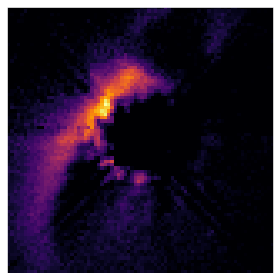

In [55]:
res = 0.0
for exp in exposures[:15]:#[:10]+exposures[11:]:
    res = res + np.nan_to_num(exp.data - exp.fit(model, exp), 0.0)/len(exposures)

res = res.at[32:48,32:48].set(0.0)

res = res - np.mean(res)

#res = res.at[45:55,45:55].set(0.0)

#res = res.at[28:36,52:60].set(0.0)


m = np.max(np.abs(res))

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

plt.imshow((res), cmap='inferno', vmax=m, vmin=-0.5)
plt.xticks([])
plt.yticks([])
#plt.colorbar()
plt.savefig("disk.png", transparent=True)

524.8547


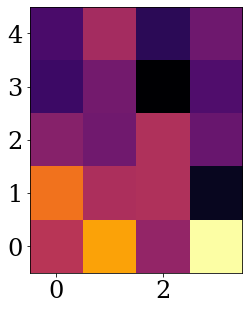

In [24]:
#plt.imshow(res[21:25,64:68])
#print(10**4.9665546 / np.sum(res[21:25,64:68]))
# gives 2223.365 for N458

plt.imshow(res[65:70, 32:36])
print(10**4.4365478 / np.sum(res[65:70, 32:36]))


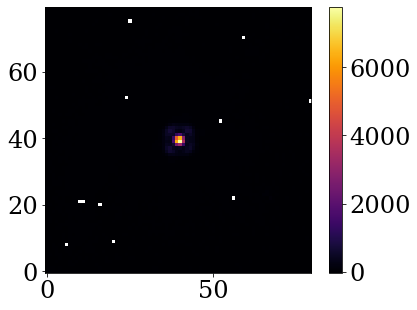

In [25]:
plt.imshow(exp.data)
plt.colorbar()

0.06597222222222222


Text(0, 0.5, 'Defocus (nm)')

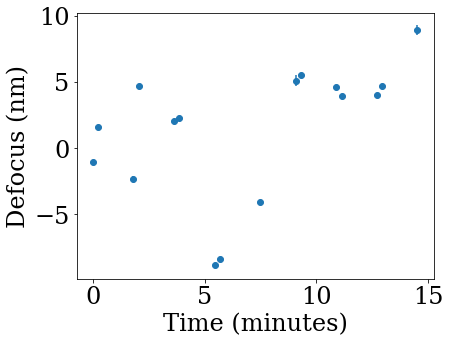

In [26]:
#orbit = 95/(24*60)

defocus = [x[0] for x in params.params["aberrations"].values()][:16]
mjd = [exp.mjd for exp in exposures][:16]

mjd = [(x - mjd[0])*24*60 for x in mjd]

print(95/(24*60))

plt.errorbar(mjd, defocus, uncs[:16], marker="o",linestyle='none')
#plt.scatter(mjd,defocus)
plt.xlabel("Time (minutes)")
plt.ylabel("Defocus (nm)")